## Functional testing for PR-302

Show that the SPM violations seen in kadi validation are from timing issues in the
eclipse exit times. Increasing the minimum violation duration from 300 to 400 seconds 
fixes things.

Show that increasing setting `ValidateRoll.max_delta_vals["NMAN"] = 12.0` removes
off-nominal roll violations.

In [1]:
import sys
sys.path.insert(0, "..")

import cheta.utils as cheta_utils
import ska_sun
from cheta import fetch
from cheta import utils

import kadi
from kadi.commands import validate
from kadi.commands.states import get_states

In [2]:
kadi.__version__

'7.7.2.dev15+ge201f44.d20231202'

In [3]:
kadi.__file__

'/Users/aldcroft/git/kadi/validate/../kadi/__init__.py'

### Find some times where SPM is showing a violation

In [4]:
# spm_val = validate.ValidateSunPosMon(stop="2023-11-07", days=4)
orig = validate.ValidateSunPosMon.min_violation_duration
validate.ValidateSunPosMon.min_violation_duration = 300
spm_val = validate.ValidateSunPosMon(stop="2023-11-04 03:00:00", days=2/24)
print(spm_val.violations)
spm_val.get_plot_figure()
validate.ValidateSunPosMon.min_violation_duration = orig


        start                  stop        
--------------------- ---------------------
2023:308:02:16:43.900 2023:308:02:21:55.500


In [5]:
# SPM enable 308:02:21:54.442 is correctly set to 11 minutes after eclipse exit
# 308:02:10:54.442. This happens from SPM auto enable by the OBC.
states = get_states(
    "2023-11-04 01:00:00", "2023-11-04 03:00:00", state_keys=["eclipse", "sun_pos_mon"]
)
states


datestart,datestop,tstart,tstop,eclipse,sun_pos_mon,trans_keys
str21,str21,float64,float64,str8,str4,object
2023:308:01:00:00.000,2023:308:01:56:34.442,815446869.184,815450263.626,DAY,ENAB,
2023:308:01:56:34.442,2023:308:02:01:34.442,815450263.626,815450563.626,DAY,DISA,sun_pos_mon
2023:308:02:01:34.442,2023:308:02:02:24.442,815450563.626,815450613.626,PENUMBRA,DISA,eclipse
2023:308:02:02:24.442,2023:308:02:10:04.442,815450613.626,815451073.626,UMBRA,DISA,eclipse
2023:308:02:10:04.442,2023:308:02:10:54.442,815451073.626,815451123.626,PENUMBRA,DISA,eclipse
2023:308:02:10:54.442,2023:308:02:21:54.442,815451123.626,815451783.626,DAY,DISA,eclipse
2023:308:02:21:54.442,2023:308:03:00:00.000,815451783.626,815454069.184,DAY,ENAB,sun_pos_mon


### Telemetry shows SPM enable at 308:02:16:43.900

This means the OBC must have decided the eclipse exit was just over 5 minutes earlier than 
predicted. So actual eclipse exit was 308:02:05:43.900 vs predicted 308:02:10:54.442.

      datestart              datestop       duration     tstart        tstop     val 
--------------------- --------------------- -------- ------------- ------------- ----
2023:308:02:10:02.100 2023:308:02:16:43.900  401.800 815451071.284 815451473.084 DISA
2023:308:02:16:43.900 2023:308:02:24:55.900  492.000 815451473.084 815451965.084 ACT 


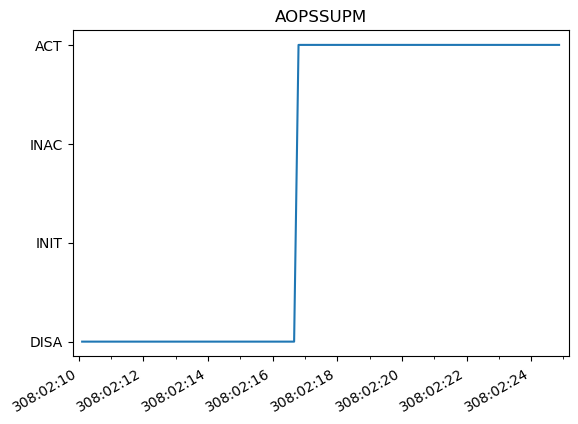

In [6]:
spm_tlm = fetch.Msid("aopssupm", "2023-11-04 02:10:00", "2023-11-04 02:25:00")
utils.state_intervals(spm_tlm.times, spm_tlm.vals).pprint_all()
spm_tlm.plot()

In [7]:
spm_val = validate.ValidateSunPosMon(stop="2023-11-04 03:00:00", days=200)
spm_val.violations

start,stop
str21,str21


### Off nominal roll

In [8]:
# Demonstrate there is a problem with the current limit of 10.0 deg for NMAN
validate.ValidateRoll.max_delta_vals["NMAN"] = 10.0
off_nom_roll_val = validate.ValidateRoll(stop="2023:172:10:00:00", days=1)
print(off_nom_roll_val.violations)
off_nom_roll_val.get_plot_figure()

        start                  stop        
--------------------- ---------------------
2023:171:14:52:47.629 2023:171:14:53:48.103
2023:171:18:18:18.378 2023:171:18:19:44.478
2023:171:22:21:58.978 2023:171:22:23:22.003
2023:172:01:31:11.879 2023:172:01:32:28.753
2023:172:05:03:01.878 2023:172:05:04:17.728


In [9]:
# Show that the problem goes away with a larger limit of 12.0 deg.
validate.ValidateRoll.max_delta_vals["NMAN"] = 12.0
off_nom_roll_val = validate.ValidateRoll(stop="2023:327:00:00:00", days=200)
print(off_nom_roll_val.violations)

start stop
----- ----
